In [1]:
"""\
# Copyright (C) 2024 Jesús Bautista Villar <jesbauti20@gmail.com>
- Testing a proportional 3D heading control algorithm -
"""

import os
import numpy as np

# -- Graphic tools --
import matplotlib.pyplot as plt

# -- Our utils --
from simulations.utils.tools_math import *
from simulations.utils.tools_plot import *

from simulations.utils.tools_basic import createDir
from simulations.sim_test import sim_test
from simulations.sim_ss_test import sim_ss_test

from simulations.utils.tools_math import rot_3d_matrix, so3_hat, so3_vee, theta_distance_from_R, exp_map, log_map_of_R

In [2]:
Ra = rot_3d_matrix(np.pi, np.pi/2, 0)
R1 = rot_3d_matrix(np.pi/3, 0, 0)
kw = 1

def omega_law(Ra, R, omega_a=np.array([0,0,0])):
    Re = Ra.T @ R
    Omega_a = so3_hat(omega_a)
    return -kw*log_map_of_R(Re) + Re.T@Omega_a@Re

alpha_list = np.linspace(0,np.pi,100)

data = np.zeros((4,len(alpha_list),3,3))
for i,alpha in enumerate(alpha_list):
    R2 = rot_3d_matrix(alpha, alpha/2, 0)
    R12 = R2.T @ R1

    Omega_1 = omega_law(Ra,R1)
    Omega_2 = omega_law(Ra,R2)

    data[0,i,...] = log_map_of_R(R2.T@R1)
    data[1,i,...] = (Omega_1 - R12.T @ Omega_2 @ R12)
    data[2,i,...] = so3_hat(so3_vee(Omega_1) - R12.T @ so3_vee(Omega_2)) # (omega_law(Ra,R1) - R1.T @ omega_law(Ra,R2) @ R1)
    data[3,i,...] = -kw*so3_hat(so3_vee(log_map_of_R(Ra.T @ R1)) - R12.T @ so3_vee(log_map_of_R(Ra.T @ R2)))



li = 10
with np.printoptions(precision=4, suppress=True):
    print(data[0,li,...], "\n---")
    print(data[1,li,...], "\n---")
    print(data[2,li,...], "\n---")
    print(data[3,li,...], "\n---")
    #print(data[4,li,...], "\n---")

[[ 0.     -0.7309 -0.1264]
 [ 0.7309  0.      0.1033]
 [ 0.1264 -0.1033  0.    ]] 
---
[[-0.      0.2974  0.8668]
 [-0.2974  0.     -0.2358]
 [-0.8668  0.2358  0.    ]] 
---
[[ 0.      0.2901  0.874 ]
 [-0.2901  0.     -0.2393]
 [-0.874   0.2393  0.    ]] 
---
[[-0.      0.2901  0.874 ]
 [-0.2901 -0.     -0.2393]
 [-0.874   0.2393 -0.    ]] 
---


[[ 1.     0.    -0.   ]
 [-0.     1.003 -0.   ]
 [ 0.     0.     1.003]]


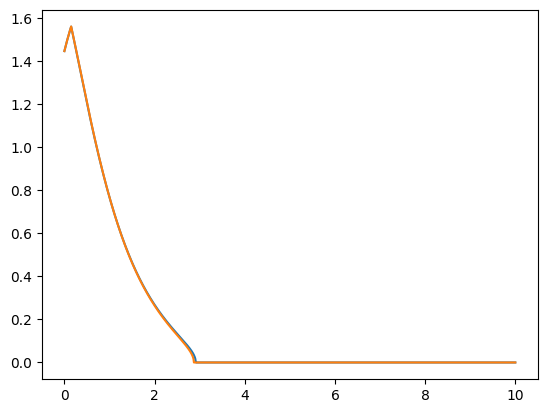

In [5]:
kw = 1
Ra = rot_3d_matrix(np.pi, -np.pi/2, 0)

R1 = rot_3d_matrix(np.pi/3, 0, 0)
R2 = rot_3d_matrix(0, np.pi/3, 0)
R12 = R2.T @ R1


def omega_law(R, omega_a=np.array([0,0,0])):
    Re = Ra.T @ R
    Omega_a = so3_hat(omega_a)
    return -kw*log_map_of_R(Re) + Re.T@Omega_a@Re

dt = 0.01
tf = 10
its = int(tf/dt)

tlist = np.linspace(0,dt*its,its)

R1_data = np.zeros((len(tlist),3,3))
R2_data = np.zeros((len(tlist),3,3))
R12_data = np.zeros((len(tlist),3,3))

R12_norm_data = np.zeros((len(tlist)))
R12_norm_pred_data = np.zeros((len(tlist)))

for i,t in enumerate(tlist):
    if i == 0:
        R1_data[i,:,:] = R1
        R2_data[i,:,:] = R2
        R12_data[i,:,:] = R12
        R12_norm_data[i] = theta_distance_from_R(R12)
        R12_norm_pred_data[i] = theta_distance_from_R(R12)

    else:
        Omega_1 = omega_law(R1_data[i-1,:,:])
        Omega_2 = omega_law(R2_data[i-1,:,:])

        R1_data[i,:,:] = R1_data[i-1,:,:]@exp_map(Omega_1*dt)
        R2_data[i,:,:] = R2_data[i-1,:,:]@exp_map(Omega_2*dt)

        #Omega_12 = (Omega_1 - R12_comp.T @ Omega_2 @ R12_comp)
        Omega_12 = -kw*so3_hat(so3_vee(log_map_of_R(Ra.T @  R1_data[i-1,:,:])) - R12_data[i-1,:,:].T @ so3_vee(log_map_of_R(Ra.T @ R2_data[i-1,:,:])))
        R12_data[i,:,:] = R12_data[i-1,:,:]@exp_map(Omega_12*dt)
        
        R12_norm_data[i] = theta_distance_from_R(R2_data[i,:,:].T@R1_data[i,:,:])
        R12_norm_pred_data[i] = theta_distance_from_R(R12_data[i,:,:])

with np.printoptions(precision=3, suppress=True):
    print(Ra.T@R1_data[-1,:,:])

plt.plot(tlist, R12_norm_data)
plt.plot(tlist, R12_norm_pred_data)
plt.show()